In [304]:
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
import pandas as pd
import pickle
import pyperclip
import seaborn as sns
import shap
import statsmodels.api as sm
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import warnings

from collections import defaultdict
from skgrf.ensemble import GRFForestLocalLinearRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Import a dictionary of whether each signal is a continuous or discrete signal
with open("data/is_continuous_signal.pkl", "rb") as f:
    is_continuous_signal = pickle.load(f)
continuous_signals = [signal for signal in is_continuous_signal if is_continuous_signal[signal]]
categorical_signals = [signal for signal in is_continuous_signal if not is_continuous_signal[signal]]

# Import cleaned data
df = pd.read_csv("data/cleaned_data.csv", index_col=["yyyymm", "permno"])

In [3]:
def backtest(models, data, train_window=10, val_window=5, test_window=2, start_year=1970, end_year=2022, use_cache=True, returns_only=False):

    def compute_score(df, scorer):
        '''
        Use the model scorer to assign a "score" column to the data.
        '''
        return df.assign(score=scorer(df.drop(columns=["ret", "ret_raw"])))

    def compute_return(df):
        return df.groupby("yyyymm").apply(compute_return_month).values
    
    def compute_return_month(scored_data):
        '''
        Sort the data by the model score and compute the average return of the top decile minus the average
        return of the bottom decile.
        '''
        sorted_data = scored_data.sort_values(by="score")
        decile_count = int(sorted_data.shape[0]/10)
        return sorted_data.ret_raw[-decile_count:].mean() - sorted_data.ret_raw[:decile_count].mean()

    def preprocess(df):
        '''
        Drop signals that are unavailable for the training period and one-hot-encode categorical variables.
        '''
        df = df.dropna(axis=1)
        return pd.get_dummies(df, columns=list(set(df.columns).intersection(categorical_signals)), drop_first=True) \
            .groupby("yyyymm") \
            .apply(preprocess_month)

    def preprocess_month(df):
        '''
        Standardize categorical variables, as well as returns. Keep raw returns in the "ret_raw" column.
        '''
        df = df.assign(ret_raw=df.ret)
        available_continuous_signals = list(set(df.columns).intersection(continuous_signals)) + ["ret"]
        df[available_continuous_signals] = StandardScaler().fit_transform(df[available_continuous_signals])
        return df

    def preprocess_ts(df):
        '''
        Produce lagged versions of all the signals for time series inputs.
        '''
        return (df.drop(columns=["ret", "ret_raw"])
                .groupby("permno")
                .apply(lambda df: pd.concat([df.shift(lag) for lag in range(12)], axis=1))
                .join(df[["ret", "ret_raw"]])
                .dropna())
        
    in_sample_model_values = []
    out_sample_model_values = []
    r2_model = []
    shap_model = []
    for model_index, model in enumerate(models):

        print(model.name())
        print(model.params())
        dynamic_train_window = train_window if model.is_dynamic() else train_window + val_window
        dynamic_val_window = val_window if model.is_dynamic() else 0
        if model.params():
            in_sample_file_name = f"backtest_results/{model.name()}/{model.params()}/in_sample/{start_year}-{end_year}-{dynamic_train_window}-{dynamic_val_window}-{test_window}.npy"
            out_sample_file_name = f"backtest_results/{model.name()}/{model.params()}/out_sample/{start_year}-{end_year}-{dynamic_train_window}-{dynamic_val_window}-{test_window}.npy"
            r2_file_name = f"backtest_results/{model.name()}/{model.params()}/r2/{start_year}-{end_year}-{dynamic_train_window}-{dynamic_val_window}-{test_window}.npy"
            shap_file_name = f"backtest_results/{model.name()}/{model.params()}/shap/{start_year}-{end_year}-{dynamic_train_window}-{dynamic_val_window}-{test_window}.pkl"
        else:
            in_sample_file_name = f"backtest_results/{model.name()}/in_sample/{start_year}-{end_year}-{dynamic_train_window}-{dynamic_val_window}-{test_window}.npy"
            out_sample_file_name = f"backtest_results/{model.name()}/out_sample/{start_year}-{end_year}-{dynamic_train_window}-{dynamic_val_window}-{test_window}.npy"
            r2_file_name = f"backtest_results/{model.name()}/r2/{start_year}-{end_year}-{dynamic_train_window}-{dynamic_val_window}-{test_window}.npy"
            shap_file_name = f"backtest_results/{model.name()}/shap/{start_year}-{end_year}-{dynamic_train_window}-{dynamic_val_window}-{test_window}.pkl"

        # Load results from cache if applicable
        if (use_cache
            and os.path.exists(in_sample_file_name)
            and os.path.exists(out_sample_file_name)
            and (returns_only or os.path.exists(r2_file_name) and os.path.exists(shap_file_name))
        ):
            in_sample_model_values.append(np.load(in_sample_file_name))
            out_sample_model_values.append(np.load(out_sample_file_name))
            if not returns_only:
                r2_model.append(np.load(r2_file_name))
                shap_model.append(pd.read_pickle(shap_file_name))
            continue

        current_year = start_year
        in_sample_portfolio_value = [1]
        out_sample_portfolio_value = [1]
        r2 = []
        shap_values = dict()

        # Loop through all years in the specified range with a rolling window
        while current_year < end_year - train_window - val_window:

            print(current_year)
            train_end_year = current_year + train_window
            val_end_year = train_end_year + val_window
            test_end_year = val_end_year + test_window

            full_window_data = preprocess(data.loc[(slice(100 * current_year, 100 * min(end_year, test_end_year)), slice(None))])

            if model.is_ts():
                full_window_data = preprocess_ts(full_window_data)

            data_train = full_window_data.loc[slice(100 * train_end_year)]
            non_constant_cols = (data_train != data_train.iloc[0]).any()
            data_train = data_train.loc[:, non_constant_cols]
            data_val = full_window_data.loc[slice(100 * train_end_year, 100 * val_end_year), non_constant_cols]
            data_train_val = full_window_data.loc[slice(100 * val_end_year), non_constant_cols]
            data_test_in_sample = full_window_data.loc[slice(100 * (train_end_year - test_window), 100 * train_end_year), non_constant_cols]
            data_test_out_sample = full_window_data.loc[slice(100 * val_end_year, None), non_constant_cols]

            # Dynamic model trains on 10 years and validates on 5 years. The model training must
            # accept a "validator" parameter, which is a function that will validate the trained
            # model on a validation set. Static model trains on 15 years and does not validate.
            model.train(
                data_train_val.drop(columns=["ret", "ret_raw"]),
                data_train_val.ret,
                data_train.drop(columns=["ret", "ret_raw"]),
                data_train.ret,
                lambda scorer: (compute_return(compute_score(data_val, scorer)) + 1).prod(),
            )

            # Simulate the model performance on 2 years, and append the simulated portfolio balances to the running list
            in_sample_scored_data = compute_score(data_test_in_sample, model.score)
            out_sample_scored_data = compute_score(data_test_out_sample, model.score)
            in_sample_portfolio_value += list((compute_return(in_sample_scored_data) + 1).cumprod() * in_sample_portfolio_value[-1])
            out_sample_portfolio_value += list((compute_return(out_sample_scored_data) + 1).cumprod() * out_sample_portfolio_value[-1])
            if not returns_only:
                r2.append(r2_score(out_sample_scored_data["ret"], out_sample_scored_data["score"]))
                shap_values[current_year] = model.shap(data_test_out_sample.drop(columns=["ret", "ret_raw"]))
            current_year += test_window

        in_sample_model_values.append(in_sample_portfolio_value)
        out_sample_model_values.append(out_sample_portfolio_value)
        if not returns_only:
            r2_model.append(r2)
            shap_values_df = pd.concat(shap_values, names=["start_date"])
            shap_model.append(shap_values_df)

        # Save results to cache if applicable
        if use_cache:
            for file_name in [in_sample_file_name, out_sample_file_name, r2_file_name, shap_file_name]:
                if not os.path.exists(os.path.dirname(file_name)):
                    os.makedirs(os.path.dirname(file_name))
            np.save(in_sample_file_name, in_sample_portfolio_value)
            np.save(out_sample_file_name, out_sample_portfolio_value)
            if not returns_only:
                np.save(r2_file_name, r2)
                shap_values_df.to_pickle(shap_file_name)

    return in_sample_model_values, out_sample_model_values, r2_model, shap_model

In [4]:
class BaseModel:
    '''
    Interface for models to implement.
    '''

    def train(self, X_train_val, y_train_val, X_train, y_train, validator):
        raise Exception("stub")

    def score(self, X):
        raise Exception("stub")

    def shap(self, X):
        raise Exception("stub")

    def name(self):
        raise Exception("stub")

    def params(self):
        return dict()

    def is_dynamic(self):
        return False

    def is_ts(self):
        return False

In [7]:
class OlsModel(BaseModel):
    '''
    Static unregularized OLS model that trains on all features.
    '''

    def train(self, X_train_val, y_train_val, X_train, y_train, validator):
        self.ols = LinearRegression().fit(X_train_val, y_train_val)

    def score(self, X):
        return self.ols.predict(X)

    def shap(self, X):
        return pd.Series(
            data=shap.explainers.Linear(self.ols, X)(X).abs.mean(0).values,
            index=X.columns,
        )

    def name(self):
        return "OLS"

In [8]:
class VanillaRFModel(BaseModel):
    '''
    Vanilla Random Forest model that trains on all features. It can be made static by supplying only
    one choice for each hyperparameter, or dynamic by supplying multiple choices in at least one hyperparameter.
    '''

    def __init__(self, n_estimators_set=[100], max_depth_set=[10], max_features_set=[1.0]):
        self.n_estimators_set = n_estimators_set
        self.max_depth_set = max_depth_set
        self.max_features_set = max_features_set

    def _fit(self, X, y, n_estimators, max_depth, max_features):
        self.rf = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            random_state=0,
            n_jobs=-1,
        )
        self.rf.fit(X.values, y.values)

    def train(self, X_train_val, y_train_val, X_train, y_train, validator):
        '''
        If this is a static model, simply fit the Random Forest model using the supplied hyperparameters.
        Otherwise, loop through the grid of hyperparameters to select which selection performs best
        against the validation set.
        '''
        if not self.is_dynamic():
            self._fit(X_train_val, y_train_val, self.n_estimators_set[0], self.max_depth_set[0], self.max_features_set[0])
            return

        best_returns = -1
        for n_estimators in self.n_estimators_set:
            for max_depth in self.max_depth_set:
                for max_features in self.max_features_set:
                    self._fit(X_train, y_train, n_estimators, max_depth, max_features)
                    returns = validator(self.score)
                    if returns > best_returns:
                        best_model = (n_estimators, max_depth, max_features)
                        best_returns = returns
        print(best_model)
        self._fit(X_train_val, y_train_val, *best_model)

    def score(self, X):
        return self.rf.predict(X.values)

    def shap(self, X):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            return pd.Series(
                data=np.abs(shap.KernelExplainer(self.rf.predict, shap.kmeans(X, 50)).shap_values(shap.sample(X, 1000))).mean(0),
                index=X.columns,
            )

    def name(self):
        return "Vanilla RF"

    def params(self):
        return {
            "n_estimators": self.n_estimators_set if len(self.n_estimators_set) > 1 else self.n_estimators_set[0],
            "max_depth": self.max_depth_set if len(self.max_depth_set) > 1 else self.max_depth_set[0],
            "max_features": self.max_features_set if len(self.max_features_set) > 1 else self.max_features_set[0],
        }

    def is_dynamic(self):
        return len(self.n_estimators_set) > 1 or len(self.max_depth_set) > 1 or len(self.max_features_set) > 1

In [9]:
class ExtraTreesModel(VanillaRFModel):
    '''
    Swap out the Vanilla Random Forest model with an Extremely Randomized Trees model.
    '''

    def _fit(self, X, y, n_estimators, max_depth, max_features):
        self.rf = ExtraTreesRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            random_state=0,
            n_jobs=-1,
        )
        self.rf.fit(X.values, y.values)

    def name(self):
        return "Extra Trees"

In [10]:
class LocalLinearForestModel(BaseModel):
    '''
    Local Linear Forest model that trains on all features.
    '''

    def __init__(self, n_estimators=100, min_node_size=5):
        self.n_estimators = n_estimators
        self.min_node_size = min_node_size

    def train(self, X_train_val, y_train_val, X_train, y_train, validator):
        self.rf = GRFForestLocalLinearRegressor(
            n_estimators=self.n_estimators,
            min_node_size=self.min_node_size,
            seed=0,
            n_jobs=-1,
        )
        self.rf.fit(X_train_val.values, y_train_val.values)

    def score(self, X):
        return self.rf.predict(X.values)

    def name(self):
        return "Local Linear Forest"

    def params(self):
        return {
            "n_estimators": self.n_estimators,
            "min_node_size": self.min_node_size,
        }

In [11]:
class FeedForwardNNModel(BaseModel):
    '''
    Simple Feedforward Neural Network model with densely connected layers
    and dropout layers between all other layers.
    '''

    def __init__(self, n_estimators=5, num_layers=1, num_nodes=32, dropout_rate=0.2, batch_size=2048):
        self.n_estimators = n_estimators
        self.num_layers = num_layers
        self.num_nodes = num_nodes
        self.dropout_rate = dropout_rate
        self.batch_size = batch_size

    def train(self, X_train_val, y_train_val, X_train, y_train, validator):
        self.nns = []
        for i in range(self.n_estimators):
            tf.random.set_seed(i)
            nn = tf.keras.Sequential()
            nn.add(tf.keras.Input((X_train_val.shape[1],)))
            for _ in range(self.num_layers):
                if self.dropout_rate > 0.0:
                    nn.add(tf.keras.layers.Dropout(self.dropout_rate))
                nn.add(tf.keras.layers.Dense(self.num_nodes, activation=tf.nn.relu))
            if self.dropout_rate > 0.0:
                nn.add(tf.keras.layers.Dropout(self.dropout_rate))
            nn.add(tf.keras.layers.Dense(1))
            nn.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError())
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)
            nn.fit(
                X_train_val.values,
                y_train_val.values,
                batch_size=self.batch_size,
                epochs=100,
                callbacks=[early_stopping],
                verbose=0,
            )
            self.nns.append(nn)

    def score(self, X):
        return np.sum([nn.predict(X.values, verbose=0) for nn in self.nns], axis=0)

    def shap(self, X):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            return pd.Series(
                data=np.sum([
                    np.abs(shap.DeepExplainer(nn, shap.kmeans(X.values, 50).data).shap_values(shap.sample(X.values, 1000)))[0].mean(0)
                    for nn in self.nns
                ], axis=0),
                index=X.columns,
            )

    def name(self):
        return "Feed Forward NN"

    def params(self):
        return {
            "n_estimators": self.n_estimators,
            "num_layers": self.num_layers,
            "num_nodes": self.num_nodes,
            "dropout_rate": self.dropout_rate,
            "batch_size": self.batch_size,
        }

In [12]:
class LstmModel(FeedForwardNNModel):
    '''
    Long Short-Term Memory model that trains on time series of all features.
    '''

    def train(self, X_train_val, y_train_val, X_train, y_train, validator):
        X_train_val = X_train_val.values.reshape([X_train_val.shape[0], 12, -1])
        y_train_val = y_train_val.values
        self.nns = []
        for i in range(self.n_estimators):
            tf.random.set_seed(i)
            nn = tf.keras.Sequential([
                tf.keras.Input((X_train_val.shape[1], X_train_val.shape[2])),
                tf.keras.layers.LSTM(self.num_nodes),
                tf.keras.layers.Dropout(self.dropout_rate),
                tf.keras.layers.Dense(1),
            ])
            nn.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError())
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)
            nn.fit(
                X_train_val,
                y_train_val,
                batch_size=self.batch_size,
                epochs=100,
                callbacks=[early_stopping],
                verbose=0,
            )
            self.nns.append(nn)

    def score(self, X):
        X = X.values.reshape([X.shape[0], 12, -1])
        return np.sum([nn.predict(X, verbose=0) for nn in self.nns], axis=0)

    def name(self):
        return "LSTM"

    def params(self):
        return {
            "n_estimators": self.n_estimators,
            "num_nodes": self.num_nodes,
            "dropout_rate": self.dropout_rate,
            "batch_size": self.batch_size,
        }

    def is_ts(self):
        return True

In [13]:
class PriceLstmModel(FeedForwardNNModel):
    '''
    LSTM model that trains on time series input of the Price signal only, and
    on single observations of all other signals.
    '''

    def train(self, X_train_val, y_train_val, X_train, y_train, validator):
        X_price_train_val = X_train_val["Price"].values.reshape([X_train_val.shape[0], 12, 1])
        X_train_val = X_train_val.drop("Price", axis=1).iloc[:, :int(X_train_val.shape[1] / 12 - 1)].values
        y_train_val = y_train_val.values
        self.nns = []
        for i in range(self.n_estimators):
            tf.random.set_seed(i)
            lstm_input = tf.keras.Input((12, 1))
            lstm_layer = tf.keras.layers.LSTM(self.num_nodes)(lstm_input)
            ff_input = tf.keras.Input((X_train_val.shape[1],))
            dense_layer = tf.keras.layers.Dense(self.num_nodes, activation=tf.nn.relu)(ff_input)
            concat_layer = tf.keras.layers.Concatenate()([lstm_layer, dense_layer])
            dropout_layer = tf.keras.layers.Dropout(self.dropout_rate)(concat_layer)
            for _ in range(self.num_layers - 1):
                dense_layer = tf.keras.layers.Dense(self.num_nodes, activation=tf.nn.relu)(dropout_layer)
                dropout_layer = tf.keras.layers.Dropout(self.dropout_rate)(dense_layer)
            output_layer = tf.keras.layers.Dense(1)(dropout_layer)
            nn = tf.keras.Model(inputs=[lstm_input, ff_input], outputs=output_layer)
            nn.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError())
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)
            nn.fit(
                [X_price_train_val, X_train_val],
                y_train_val,
                batch_size=self.batch_size,
                epochs=100,
                callbacks=[early_stopping],
                verbose=0,
            )
            self.nns.append(nn)

    def score(self, X):
        X_price = X["Price"].values.reshape([X.shape[0], 12, 1])
        X = X.drop("Price", axis=1).iloc[:, :int(X.shape[1] / 12 - 1)].values
        return np.sum([nn.predict([X_price, X], verbose=0) for nn in self.nns], axis=0)

    def name(self):
        return "Price LSTM"

    def params(self):
        return {
            "n_estimators": self.n_estimators,
            "num_layers": self.num_layers,
            "num_nodes": self.num_nodes,
            "dropout_rate": self.dropout_rate,
            "batch_size": self.batch_size,
        }

    def is_ts(self):
        return True

In [251]:
models = [
    OlsModel(),
    VanillaRFModel(n_estimators_set=[300], max_depth_set=[8], max_features_set=[5]),
    # # VanillaRFModel(n_estimators_set=[300], max_depth_set=[12], max_features_set=[20]),
    # # VanillaRFModel(n_estimators_set=[300], max_depth_set=[15], max_features_set=[20]),
    # # VanillaRFModel(n_estimators_set=[300], max_depth_set=[1, 3, 6], max_features_set=[5, 10, 20, 30]),
    # # VanillaRFModel(n_estimators_set=[300], max_depth_set=[6, 8, 10], max_features_set=[5, 10]),
    # # VanillaRFModel(n_estimators_set=[300], max_depth_set=[6, 8, 10], max_features_set=[10, 20, 30]),
    # # VanillaRFModel(n_estimators_set=[300], max_depth_set=[10, 12, 15], max_features_set=[15, 20, 25]),
    # # ExtraTreesModel(n_estimators_set=[300], max_depth_set=[8], max_features_set=[5]),
    ExtraTreesModel(n_estimators_set=[300], max_depth_set=[12], max_features_set=[20]),
    # # ExtraTreesModel(n_estimators_set=[300], max_depth_set=[15], max_features_set=[20]),
    # # ExtraTreesModel(n_estimators_set=[300], max_depth_set=[1, 3, 6], max_features_set=[5, 10, 20, 30]),
    # # ExtraTreesModel(n_estimators_set=[300], max_depth_set=[6, 8, 10], max_features_set=[5, 10]),
    # # ExtraTreesModel(n_estimators_set=[300], max_depth_set=[6, 8, 10], max_features_set=[10, 20, 30]),
    # # ExtraTreesModel(n_estimators_set=[300], max_depth_set=[10, 12, 15], max_features_set=[15, 20, 25]),
    # # LocalLinearForestModel(),
    # # LocalLinearForestModel(min_node_size=25),
    # # LocalLinearForestModel(min_node_size=100),
    # # LocalLinearForestModel(min_node_size=500),
    # # LocalLinearForestModel(min_node_size=2500),
    LocalLinearForestModel(min_node_size=10000),
    # # FeedForwardNNModel(),
    # # FeedForwardNNModel(num_layers=2, dropout_rate=0),
    FeedForwardNNModel(num_layers=2, dropout_rate=.1),
    # # FeedForwardNNModel(num_layers=2),
    # # FeedForwardNNModel(num_layers=2, num_nodes=64, dropout_rate=.1),
    # # FeedForwardNNModel(num_layers=3),
    # # LstmModel(num_nodes=16, dropout_rate=0),
    LstmModel(num_nodes=16, dropout_rate=.1),
    # # LstmModel(num_nodes=16),
    # # LstmModel(num_nodes=32),
    # # PriceLstmModel(),
    # # PriceLstmModel(num_layers=2, dropout_rate=.1),
    PriceLstmModel(num_layers=2),
]
in_sample_model_values, out_sample_model_values, r2_model, shap_model = backtest(models, df, returns_only=True)

OLS
{}
Vanilla RF
{'n_estimators': 300, 'max_depth': 8, 'max_features': 5}
Extra Trees
{'n_estimators': 300, 'max_depth': 12, 'max_features': 20}
Local Linear Forest
{'n_estimators': 100, 'min_node_size': 10000}
Feed Forward NN
{'n_estimators': 5, 'num_layers': 2, 'num_nodes': 32, 'dropout_rate': 0.1, 'batch_size': 2048}
LSTM
{'n_estimators': 5, 'num_nodes': 16, 'dropout_rate': 0.1, 'batch_size': 2048}
Price LSTM
{'n_estimators': 5, 'num_layers': 2, 'num_nodes': 32, 'dropout_rate': 0.2, 'batch_size': 2048}


In [270]:
factors = pd.read_csv('data/F-F_Research_Data_Factors.CSV', skiprows=3, index_col=0, nrows=1157) / 100
factors.index.names = ['yyyymm']

In [112]:
shap_dicts = [defaultdict(list) for _ in range(4)]
for i in range(4):
    for row in shap_model[i].droplevel('start_date').iteritems():
        shap_dicts[i][row[0]].append(row[1])
        
mean_shaps = pd.DataFrame(dtype=float)
names = ['OLS', 'RF', 'ERT', 'FNN']
for i in range(4):
    for key in shap_dicts[i]:
        mean_shaps.loc[key, names[i]] = np.mean(shap_dicts[i][key])

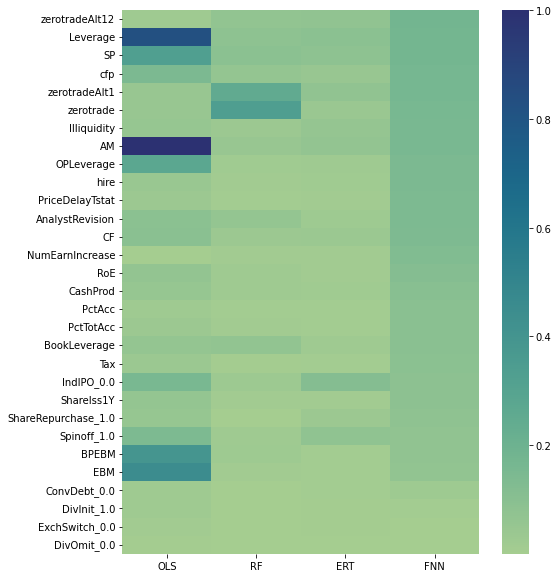

In [159]:
fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(mean_shaps.sort_values(by='FNN', ascending=False).divide(mean_shaps.max()).iloc[31:], cmap="crest", ax=ax)
plt.savefig('outputs/shap2.png', bbox_inches='tight')

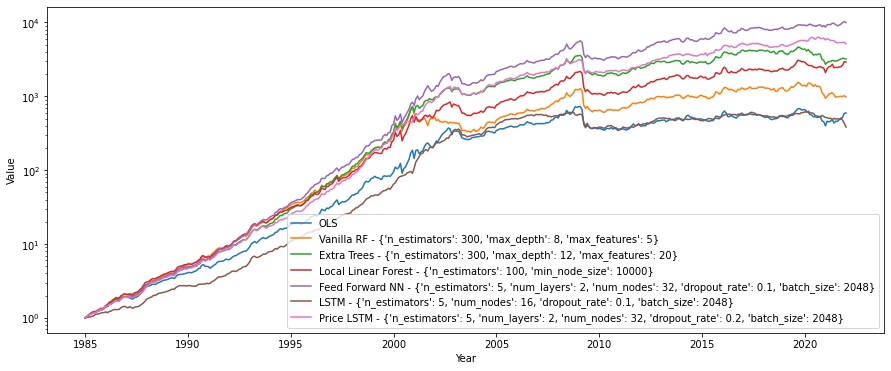

In [59]:
plt.figure(figsize=(15,6))
for model, portfolio_values in zip(models, out_sample_model_values):
    start_year = 1985
    portfolio_values = np.array(portfolio_values)
    plt.plot([start_year + i/12 for i in range(portfolio_values.shape[0])], portfolio_values, label=f"{model.name()} - {model.params()}" if model.params() else model.name())
plt.xlabel("Year")
plt.ylabel("Value")
plt.yscale("log")
plt.legend()
plt.show()

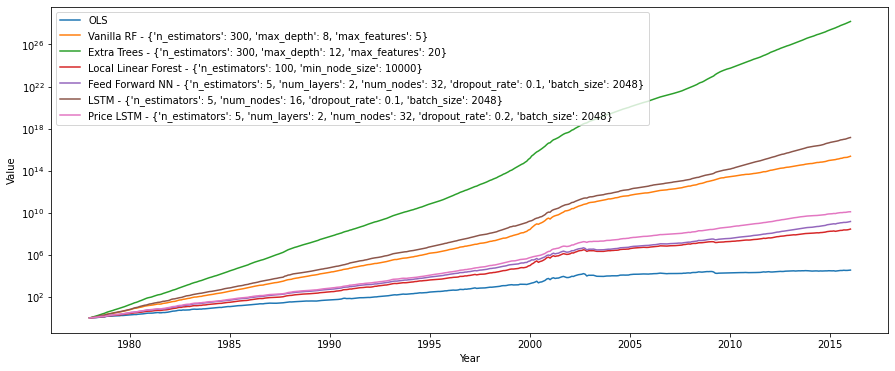

In [60]:
plt.figure(figsize=(15,6))
for model, portfolio_values in zip(models, in_sample_model_values):
    portfolio_values = np.array(portfolio_values)
    plt.plot([1978 + i/12 for i in range(portfolio_values.shape[0])], portfolio_values, label=f"{model.name()} - {model.params()}" if model.params() else model.name())
plt.xlabel("Year")
plt.ylabel("Value")
plt.yscale("log")
plt.legend()
plt.show()

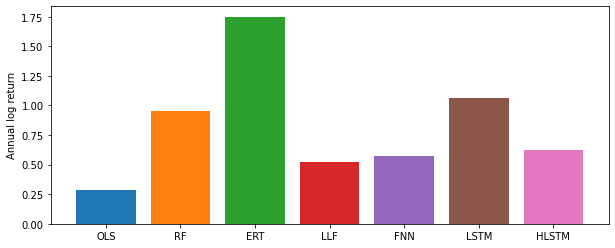

In [299]:
names = ['OLS', 'RF', 'ERT', 'LLF', 'FNN', 'LSTM', 'HLSTM']
plt.figure(figsize=(10, 4))
for i in range(7):
    plt.bar(names[i], np.log(in_sample_model_values[i] + 1) * 12 / 445, color=f'C{i}')
plt.ylabel('Annual log return')
plt.savefig('outputs/overfit.png')

In [305]:
means = []
stds = []
sharpes = []
for i in range(7):
    returns = pd.Series(out_sample_model_values[i], dates_yyyymm).pct_change().dropna()
    excess_returns = returns - factors['RF'].align(returns, join='right')[0]
    means.append(str(round(excess_returns.mean() * 12 * 100, 1)))
    stds.append(str(round(excess_returns.std() * 12**.5 * 100, 1)))
    sharpes.append(str(round(excess_returns.mean() * 12**.5 / excess_returns.std(), 2)))

table = '''\\begin{tabular}{c|c|c|c|c|c|c|c}
\t& OLS & RF & ERT & LLF & FNN & LSTM & HLSTM\\\\
\t\hline
'''
table += f"\tMean & {' & '.join(means)} \\\\\n"
table += f"\tStd. Dev. & {' & '.join(stds)} \\\\\n"
table += f"\tSharpe & {' & '.join(sharpes)} \\\\\n"
table += '\\end{tabular}'
pyperclip.copy(table)

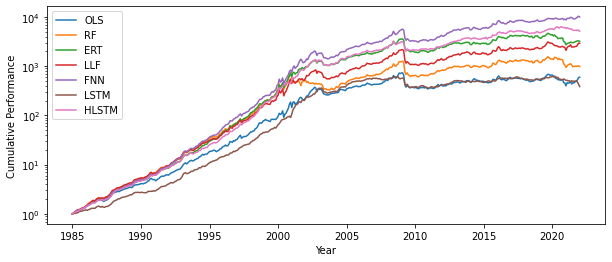

In [61]:
dates = [1985 + i/12 for i in range(445)]
plt.figure(figsize=(10, 4))
plt.plot(dates, out_sample_model_values[0], label="OLS")
plt.plot(dates, out_sample_model_values[1], label="RF")
plt.plot(dates, out_sample_model_values[2], label="ERT")
plt.plot(dates, out_sample_model_values[3], label="LLF")
plt.plot(dates, out_sample_model_values[4], label="FNN")
plt.plot(dates, out_sample_model_values[5], label="LSTM")
plt.plot(dates, out_sample_model_values[6], label="HLSTM")
plt.xlabel("Year")
plt.ylabel("Cumulative Performance")
plt.yscale("log")
plt.legend()
plt.savefig("outputs/all.png")

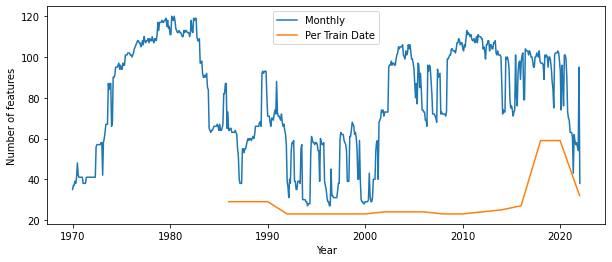

In [107]:
plt.figure(figsize=(10, 4))
plt.plot(
    pd.to_datetime(df.index.get_level_values('yyyymm').unique(), format='%Y%m')[529:-1],
    df.groupby('yyyymm').apply(lambda df: df.dropna(axis=1).columns.values.shape[0]).iloc[529:-1],
    label='Monthly',
)
plt.plot(
    [pd.to_datetime('1986', format='%Y') + i*pd.Timedelta(days=730) for i in range(19)],
    shap_model[0].groupby('start_date').count(),
    label='Per Train Date'
)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of features')
plt.savefig('outputs/availability.png')